In [230]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm # for progress bar

Randomization test is adapted from: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001010

In [263]:
# import mutations
fname = "all_mutations.annotated.filtered.csv"
df = pd.read_csv(fname)

df['genotype'] = df['file'].str.split("/").str[2].str.split("_").str[0]
df['rep'] = df['file'].str.split("/").str[2].str.split("_").str[2]
df['passage'] = df['file'].str.split("/").str[2].str.split("_").str[1]
df['n_var'] = df['Rvar'] + df['Fvar']
df['n_tot'] = df['Rtot'] + df['Ftot']
df['frequency'] = df['n_var'] / df['n_tot']
df['position'] = df['POS'] 
df['mutation'] = df['REF'] + df['POS'].astype(str) + df['ALT']

df['mutation_id'] = df['position'].astype('str')+df['ALT']
df['line_id'] = df['genotype']+'_'+df['rep']

# crpv
df = df[df['virus']=='crpv']

## Prepare data (exclude mutations that already occurr in parental stock) 

In [264]:
parental_mutations = df[df['genotype']=='parental']['mutation_id'].unique()

df = df[
    (df['genotype']!='parental') #& 
    #(~df['mutation_id'].isin(parental_mutations))
]


In [265]:
threshold = 0.01 # majority mutations frequency threshold
n_samples = 100 #number of randomizations to perform

np.random.seed(111111) #makes results reproducable, seed was randomly generated before first run

In [267]:
# Prepare dataframe 

# filter for majority mutations
# majority = with observed mutation frequency >= threshold
muts_high_freq = df[df['frequency']>=threshold]['mutation_id']

df['mutation_id+line_id'] = df['mutation_id'] + df['line_id']

df_pivot = df[df['mutation_id'].isin(muts_high_freq)].pivot_table(values='frequency', 
                          index = 'mutation_id',
                          columns='line_id',
                          aggfunc={'frequency': lambda x : True},
                          fill_value=False 
                         )

df_pivot = df[df['frequency']>=threshold].pivot_table(values='frequency', 
                          index = 'mutation_id',
                          columns='line_id',
                          aggfunc={'frequency': lambda x : True},
                          fill_value=False 
                         )

df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.set_index('mutation_id')

In [268]:
df_pivot

line_id,I_a,I_b,I_c,K_a,K_b,K_c,W_a,W_b,W_c
mutation_id,,,,,,,,,
1023T,False,False,False,False,True,False,False,False,False
1075T,False,False,False,False,False,True,False,False,False
1077T,False,False,True,False,False,False,False,False,False
1084C,False,True,False,False,False,False,False,False,False
1088C,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
923G,False,False,False,True,False,False,False,False,False
939C,False,True,False,True,False,False,False,False,False
942T,False,False,False,False,False,False,True,True,False


## Randomization

In [269]:
def randomize(dataframe):
    '''randomize a dataframe with rows of true/falses, to keep the number of true/falses per row, 
    but change the exact positions'''
    
    # Compute probability of choosing experimental line
    n_mutations_per_line = dataframe.sum()
    weight_of_line = n_mutations_per_line/n_mutations_per_line.sum() 
    #print("weight_of_line" , weight_of_line)
    
    n_lines_mut_occurs_in = dataframe.sum(1).astype(int)
    
    randomized = [
        np.random.choice(dataframe.columns,p=weight_of_line,size=i,replace=False) 
        for i in n_lines_mut_occurs_in
    ]
    
    return pd.DataFrame(
        [dataframe.columns.isin(i) for i in randomized],columns=dataframe.columns,index=dataframe.index
    )

In [270]:
# list of n_samples random realization of the mutation dataframe
random = [randomize(df_pivot) for i in tqdm(range(1),leave=False, desc='randomizing')]

In [271]:
n_mutations_per_line = random[0].sum()
weight_of_line = n_mutations_per_line/n_mutations_per_line.sum() 
print("weight_of_line" , weight_of_line)
    

weight_of_line line_id
I_a    0.097701
I_b    0.101533
I_c    0.105364
K_a    0.091954
K_b    0.116858
K_c    0.118774
W_a    0.118774
W_b    0.114943
W_c    0.134100
dtype: float64


In [272]:
# list of n_samples random realization of the mutation dataframe
random = [randomize(df_pivot) for i in tqdm(range(n_samples),leave=False, desc='randomizing')]

In [273]:
lines_WT = ['W_a', 'W_b', 'W_c']

lines_OE = ['I_a', 'I_b','I_c']

lines_KO = ['K_a', 'K_b', 'K_c']

## Prepare plotting 

In [274]:
# Prepare results for plotting
to_plot = {}

In [275]:
# mutations that are shared only in one GT 

for shared_in_GT, lines_GT in zip(['WT only', 'KO only', 'IP only'], [lines_WT, lines_KO, lines_OE]):

    # select mutations that only occur in one GT
    same = df_pivot[lines_GT].sum(1) == df_pivot.sum(1)
    mut_table_here = df_pivot[same] 
    
    # add observation 
    to_plot[shared_in_GT] = [(mut_table_here.sum(1)>1).sum()]
    
    # add what is expected from the randomization test
    rands = []
    for r in random:
        same = r[lines_GT].sum(1) == r.sum(1)
        mut_table_here = r[same]
        rands.append((mut_table_here.sum(1)>1).sum())
        
    to_plot[shared_in_GT].append(rands)

In [276]:
# mutations that are shared in two genotypes 

# add observations 
set_of_mutations_WT = set(df_pivot[(df_pivot[lines_WT].sum(1)>0)].index)
set_of_mutations_KO = set(df_pivot[(df_pivot[lines_KO].sum(1)>0)].index)
set_of_mutations_OE = set(df_pivot[(df_pivot[lines_OE].sum(1)>0)].index)

shared_mutation_WT_OE = set_of_mutations_WT.intersection(set_of_mutations_OE) - set_of_mutations_KO
shared_mutation_WT_KO = set_of_mutations_WT.intersection(set_of_mutations_KO) - set_of_mutations_OE
shared_mutation_OE_KO = set_of_mutations_OE.intersection(set_of_mutations_KO) - set_of_mutations_WT

to_plot['shared IP and WT'] = [(df_pivot.loc[list(shared_mutation_WT_OE)].sum(1)>1).sum()]
to_plot['shared KO and WT'] = [(df_pivot.loc[list(shared_mutation_WT_KO)].sum(1)>1).sum()]
to_plot['shared IP and KO'] = [(df_pivot.loc[list(shared_mutation_OE_KO)].sum(1)>1).sum()]

# add from randomization tests  

# shared OE and WT
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    shared_mutation_WT_OE = set_of_mutations_WT.intersection(set_of_mutations_OE) - set_of_mutations_KO
    
    rands.append((r.loc[list(shared_mutation_WT_OE)].sum(1)>1).sum())
to_plot['shared IP and WT'].append(rands)

# shared KO and WT
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index) 
    shared_mutation_WT_KO = set_of_mutations_WT.intersection(set_of_mutations_KO) - set_of_mutations_OE
    
    rands.append((r.loc[list(shared_mutation_WT_KO)].sum(1)>1).sum())
to_plot['shared KO and WT'].append(rands)

# shared OE and KO
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    shared_mutation_OE_KO = set_of_mutations_OE.intersection(set_of_mutations_KO) - set_of_mutations_WT
    
    rands.append((r.loc[list(shared_mutation_OE_KO)].sum(1)>1).sum())
to_plot['shared IP and KO'].append(rands)

# mutations that are shared between all three genotypes
# add observations 
set_of_mutations_WT = set(df_pivot[(df_pivot[lines_WT].sum(1)>0)].index)
set_of_mutations_KO = set(df_pivot[(df_pivot[lines_KO].sum(1)>0)].index)
set_of_mutations_OE = set(df_pivot[(df_pivot[lines_OE].sum(1)>0)].index)
shared_mutations_WT_OE_KO = set_of_mutations_WT.intersection(set_of_mutations_OE, set_of_mutations_KO)

# add observations 
to_plot['shared KO, IP and WT'] = [(df_pivot.loc[list(shared_mutations_WT_OE_KO)].sum(1)>=3).sum()]

# add from randomization tests  
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index)
    shared_mutations_WT_OE_KO = set_of_mutations_WT.intersection(set_of_mutations_OE, set_of_mutations_KO)

    rands.append((r.loc[list(shared_mutations_WT_OE_KO)].sum(1)>1).sum())
to_plot['shared KO, IP and WT'].append(rands)



## Statisics on sharing

In [277]:
total = sum([to_plot[i][0] for i in to_plot])
shared = sum([to_plot[i][0] for i in to_plot if 'shared' in i])
print('total number of mutations: ',total)
#print('shared mutations: {}, {}%'.format(shared, 100*shared/total) )
#print('shared mutations, all genotypes: {}, {}%'.format(to_plot['shared KO, IP and WT'][0],                                                    100*to_plot['shared KO, OE and WT'][0]/total) )


total number of mutations:  58


## Plotting 

In [278]:
def p_code(p):
    if p<0.001:
        return '***'
    if p< 0.01:
        return '**'
    if p < 0.05:
        return '*'
    if p < 0.1:
        return '.'
    return ''

WT only  :  7
WT only  :  3.58
KO only  :  10
KO only  :  2.62
IP only  :  9
IP only  :  2.86
shared IP and WT  :  7
shared IP and WT  :  10.66
shared KO and WT  :  5
shared KO and WT  :  10.25
shared IP and KO  :  5
shared IP and KO  :  9.3
shared KO, IP and WT  :  15
shared KO, IP and WT  :  18.73


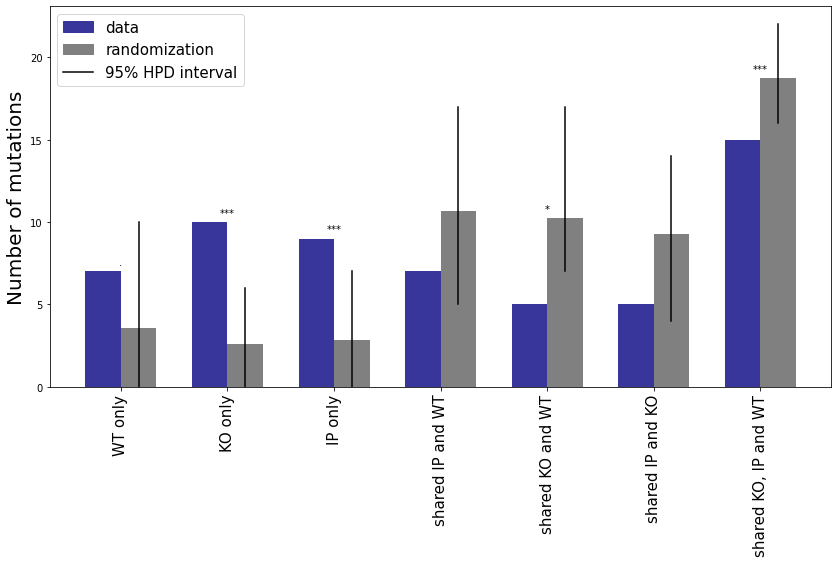

In [279]:


fig = plt.figure(figsize=[14,7])
pos = 0
xpos = []
xlabel = []
for category in to_plot.keys():
        plt.bar(pos,to_plot[category][0],color='#38369A',width=0.5)
        print(category, " : ", to_plot[category][0])
        xpos.append(pos+0.25)
        pos+=0.5
        xlabel.append(category)
        mean = np.mean(to_plot[category][1])
        print(category, " : ", mean)
        plt.bar(pos, mean,color='grey',width=0.5)
        ci = [sorted(to_plot[category][1])[int(n_samples*0.025)],
              sorted(to_plot[category][1])[-int(n_samples*0.025)]]

        plt.plot([pos,pos],ci,color='black')

        p = 1-2*abs((1.0*sum(np.array(to_plot[category][1])>to_plot[category][0])/n_samples)-0.5)
        #print("p ", p)
        #print("final_adjusted_p", final_adjusted_p)

        plt.text(pos-0.25,max(to_plot[category][0],mean)+0.25,p_code(p),
                 va='bottom',ha='center')
        pos+=1

plt.xticks(xpos,xlabel,fontsize=15, rotation=90)
plt.ylabel('Number of mutations',fontsize=20)

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

data = mpatches.Patch(color='#38369A', label='data')
random = mpatches.Patch(color='grey', label='randomization')
hpd = Line2D([0],[0],label='95% HPD interval',color='black')

plt.legend(handles=[data,random,hpd],fontsize=15)
#plt.savefig('fig4_effect_environment.pdf')
plt.show()



In [ ]:
# adjust p-value (correct for multiple testing)

